# Part 2: Running Cortex Certifai Scan on models packaged and deployed as service in Azure ML Notebook

# Typical flow for a ML Engineer during Development


## CONTENTS

1. Pick up where the Data Scientist left off.

2. Register model and deploy as webservice in ACI (AZURE CONTAINER INSTANCE) with authentication

3. Test the deployed webservice

4. Run Certifai Scan on the model deployed as webservice

## Documentation

Visit the Certifai Documentation here https://cognitivescale.github.io/cortex-certifai/docs/about

## Prerequisites

Note: If you have not completed part 1, See Prerequisites section in part1_certifai_workshop_inline_scan.ipynb for details

### Set Cortex Certifai Toolkit path
- update the `certifai_toolkit_path` to point your downloaded toolkit
- this will be used later to install cortex certifai python packages

In [18]:
from pathlib import Path
pwd = !pwd
my_path = str(Path(pwd[0]).parents[0])
certifai_toolkit_path = my_path  + '/certifai_toolkit_1.3.3'
certifai_toolkit_path

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/sko-compute-1-3-2i/code/users/skottaram/msft-workshop/certifai_toolkit_1.3.3'

## Creating a [german credit](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) prediction model using sklearn

In [19]:
# required imports for model building and persistance 

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import random
from sklearn.externals import joblib

### Test to confirm correct version of scikit-learn and numpy are installed

In [20]:
import sklearn as sklearn_version_test
assert sklearn_version_test.__version__ == '0.20.3', 'scikit-learn version mismatch, `pip install scikit-learn==0.20.3` to install right sklearn version for this notebook'
assert np.__version__                   == '1.16.2', 'numpy version mismatch, `pip install numpy==1.16.2` to install right numpy version for this notebook'

In [21]:
# special import - 
# for multiprocessing to work in a Notebook,  pickled classes must be in a separate package or notebook
# hence, the model encoder class has to be somewhere other than the current notebook

import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('.')))
from scripts.cat_encoder import CatEncoder

###  load data in dataframe

In [22]:
# load the dataset into memory
df = pd.read_csv('data/german_credit_eval.csv')

### define features 

In [23]:
cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'status',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

label_column = 'outcome'

### separate features and target variable

In [24]:
y = df[label_column]
X = df.drop(label_column, axis=1)

### split dataset into the training and test set

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### encode and scale features

In [26]:
encoder = CatEncoder(cat_columns, X)

/anaconda/envs/certifai-azure-model-env-1.3.3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


### build and train model using sklearn

In [27]:
def build_model(data, name, model_family, test=None):
    if test is None:
        test = data
        
    if model_family == 'SVM':
        parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, .5, 1, 2, 4, 10], 'gamma':['auto']}
        m = svm.SVC()
    elif model_family == 'logistic':
        parameters = {'C': (0.5, 1.0, 2.0), 'solver': ['lbfgs'], 'max_iter': [1000]}
        m = LogisticRegression()
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(data[0], data[1])

    # Assess on the test data
    accuracy = model.score(test[0], test[1].values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model

svm_model_name      = 'german_credit_svm'
logistic_model_name = 'german_credit_logit'

svm_model = build_model((encoder(X_train.values), y_train),
                        svm_model_name,
                        'SVM',
                        test=(encoder(X_test.values), y_test))

logistic_model = build_model((encoder(X_train.values), y_train),
                        logistic_model_name,
                        'logistic',
                        test=(encoder(X_test.values), y_test))

/anaconda/envs/certifai-azure-model-env-1.3.3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda/envs/certifai-azure-model-env-1.3.3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Model 'german_credit_svm' accuracy is 0.77


/anaconda/envs/certifai-azure-model-env-1.3.3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda/envs/certifai-azure-model-env-1.3.3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Model 'german_credit_logit' accuracy is 0.77


### dump the trained models (along with corresponding encoder object) to disk 

In [28]:
# encoder object is dumped(along with trained model) to apply same transformation during prediction
def dump_model(model_name,model_obj,encoder_obj=encoder):
    model_path = f'{model_name}.pkl'
    model_obj = {
        "model":model_obj,
        "encoder":encoder_obj
    }
    joblib.dump(value=model_obj, filename=model_path)
    print(f'model saved on disk {model_obj}')
    return model_path

# persist models to disk
svm_model_disk_path      = dump_model(svm_model_name,svm_model)
logistic_model_disk_path = dump_model(logistic_model_name,logistic_model)

model saved on disk {'model': GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ('linear', 'rbf', 'poly'), 'C': [0.1, 0.5, 1, 2, 4, 10], 'gamma': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0), 'encoder': <scripts.cat_encoder.CatEncoder object at 0x7ff40e23f5c0>}
model saved on disk {'model': GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, v

## In the section below we will:

1. Configure Azure workspace
2. Register models (built above) to the workspace
3. Create a prediction environment in the remote Azure workspace (created above) and
4. Deploy models (predict) as web service

### Configure and Initialize Azure workspace

- Follow the instructions listed here [creating and managing azure-ml workspace](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-manage-workspace) to create an azure-ml workspace

**Once you have the workspace created easiest way to run through remaining steps is to download the `config.json` to the current directory and replace the exisiting config.json**

### Create a [Workspace](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.workspace%28class%29?view=azure-ml-py) object from the persisted configuration.

In [29]:
from azureml.core import Workspace
ws = Workspace.from_config()

### Register models to created  workspace

Register a file or folder as a model by calling [Model.register()](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.model.model?view=azure-ml-py#register-workspace--model-path--model-name--tags-none--properties-none--description-none--datasets-none--model-framework-none--model-framework-version-none--child-paths-none-).

In addition to the content of the model file itself (model + scaler object), our registered model will also store model metadata like model description, tags, etc. -- that will be useful when managing and deploying models in our workspace.

In [30]:
from azureml.core.model import Model

logistic_model_azure = Model.register(model_path=logistic_model_disk_path,
                       model_name=logistic_model_name,
                       tags={'area': "banking credit risk", 'type': "classification"},
                       description="Logistic Classifier model to predict credit loan approval",
                       workspace=ws)

svm_model_azure = Model.register(model_path=svm_model_disk_path,
                       model_name=svm_model_name,
                       tags={'area': "banking credit risk", 'type': "classification"},
                       description="Support Vector Machine Classifier model to predict credit loan approval",
                       workspace=ws)

Registering model german_credit_logit
Registering model german_credit_svm


### Create a custom prediction environment inside azure-ml workspace

If we want control over how our model is run, if it uses another framework, or if it has special runtime requirements, we can instead specify our own environment and scoring method. Custom environments can be used for any model we want to deploy.

Specify the model's runtime environment by creating an [Environment](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.environment%28class%29?view=azure-ml-py) object and providing the [CondaDependencies](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.conda_dependencies.condadependencies?view=azure-ml-py) needed by the model

In this example we will create a conda environment for our german credit model from file **myenv.yml** and register it to our workspace


In [31]:
with open("myenv.yml", 'r') as f:
    print(f.read())

name: project_environment
dependencies:
  - python=3.6.2
  - scikit-learn==0.20.3
  - numpy==1.16.2
  - pip:
    - azureml-defaults
    - inference-schema[numpy-support]
    


In [32]:
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.environment import Environment

environment = Environment("german-credit-env")
environment.python.conda_dependencies = CondaDependencies("myenv.yml")
environment.register(workspace=ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/base:intelmpi2018.3-ubuntu16.04",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "username": null
        },
        "enabled": false,
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "german-credit-env",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "dependencies": [
                "python=3.6.2",
                "scikit-learn==0.20.3",
                "numpy==1.16.2",
                {
                    "pip": [
                        "azureml-defa


## Create Inference Configuration and deploy webservice

**Inference Configuration** will contain:

1. Scoring script
2. Environment (created above)

We create the scoring script, called **score.py**. The web service call uses this script to show how to use the model.

We include below two required functions in the scoring script:

1. The `init()` function, which typically loads the model into a global object. This function is run only once when the Docker container is started.

2. The `run(data)` function uses the model to predict a value based on the input data. Inputs and outputs to the run typically use JSON for serialization and de-serialization, but other formats are also supported.




Deploy the registered model in the custom environment by providing an [InferenceConfig](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.model.inferenceconfig?view=azure-ml-py) object to [Model.deploy()](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.model.model?view=azure-ml-py#deploy-workspace--name--models--inference-config--deployment-config-none--deployment-target-none-). In this case we are also using the [AciWebservice.deploy_configuration()](https://docs.microsoft.com/python/api/azureml-core/azureml.core.webservice.aci.aciwebservice#deploy-configuration-cpu-cores-none--memory-gb-none--tags-none--properties-none--description-none--location-none--auth-enabled-none--ssl-enabled-none--enable-app-insights-none--ssl-cert-pem-file-none--ssl-key-pem-file-none--ssl-cname-none--dns-name-label-none--) method to generate a custom deploy configuration
        
**Note**: This step can take several minutes.


In [33]:
with open('scripts/svm_score.py') as f:
    print(f.read())

import os
import json
import numpy as np
from sklearn.externals import joblib
import traceback


def init():
    global model
    global encoder
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'german_credit_svm.pkl')
    # deserialize the model_obj file back into a sklearn model and scaler object
    model_obj  = joblib.load(model_path)
    model      = model_obj.get('model')
    encoder    = model_obj.get('encoder')


def run(data):
    try: 
        # certifai invokes model with the json schema -> {"payload": {"instances": [ [6,107,88,0,0,36.8,0.727,31], [5,100,80,0,0,31.9,0.61,33] ]}}
        data  = json.loads(data).get('payload', {}).get('instances', [])
        data  = np.array(data, dtype=object)
        data

In [34]:
from azureml.core.model import InferenceConfig
from azureml.core import Webservice
from azureml.exceptions import WebserviceException
from azureml.core.webservice import AciWebservice

inference_config_logistic = InferenceConfig(entry_script="logistic_score.py",
                                   environment=environment,source_directory="scripts")
inference_config_svm = InferenceConfig(entry_script="svm_score.py",
                                   environment=environment,source_directory="scripts")

logistic_service_name = 'german-credit-logistic-svc-sko11'
svm_service_name = 'german-credit-svm-svc-sko11'

aci_deployment_config = AciWebservice.deploy_configuration(auth_enabled=True, cpu_cores=1, memory_gb=4)

# Remove any existing services under the same name.
try:
    Webservice(ws, logistic_service_name).delete()
except WebserviceException:
    pass

try:
    Webservice(ws, svm_service_name).delete()
except WebserviceException:
    pass


service_logistic = Model.deploy(ws, logistic_service_name, [logistic_model_azure],inference_config=inference_config_logistic,deployment_config=aci_deployment_config)
service_svm      = Model.deploy(ws, svm_service_name,      [svm_model_azure],     inference_config=inference_config_svm,     deployment_config=aci_deployment_config)
service_logistic.wait_for_deployment(show_output=True)
service_svm.wait_for_deployment(show_output=True)

Running...............................
Succeeded
ACI service creation operation finished, operation "Succeeded"
SucceededACI service creation operation finished, operation "Succeeded"


## Test the webservice

1. Get the webservice endpoint using `service.scoring_uri` :: string
2. Get the authentication headers usinh `service.get_keys()` :: tuple


In [ ]:
service_logistic_uri  = service_logistic.scoring_uri
service_logistic_keys = service_logistic.get_keys()

service_svm_uri       = service_svm.scoring_uri
service_svm_keys      = service_svm.get_keys()

print(f"service_logistic_uri - {service_logistic_uri}")
print(f"service_logistic_key - {service_logistic_keys[0]}")

print(f"service_svm_uri - {service_svm_uri}")
print(f"service_svm_key - {service_svm_keys[0]}")

In [36]:
# create json test data sample(from csv)

import json
sample_input = json.dumps({
"payload": {
    "instances": [
        [
            "... < 0 DM",
            6,
            "critical account/ other credits existing (not at this bank)",
            "radio/television",
            1169,
            "unknown/ no savings account",
            ".. >= 7 years",
            4,
            "male : single",
            "others - none",
            4,
            "real estate",
            "> 25 years",
            "none",
            "own",
            2,
            "skilled employee / official",
            1,
            "phone - yes, registered under the customers name",
            "foreign - yes"
        ]
    ]
}
})
sample_input

'{"payload": {"instances": [["... < 0 DM", 6, "critical account/ other credits existing (not at this bank)", "radio/television", 1169, "unknown/ no savings account", ".. >= 7 years", 4, "male : single", "others - none", 4, "real estate", "> 25 years", "none", "own", 2, "skilled employee / official", 1, "phone - yes, registered under the customers name", "foreign - yes"]]}}'

In [37]:
import requests
import json

headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {service_svm_keys[0]}'          
          }

response = requests.post(
    service_svm_uri, data=sample_input, headers=headers)
print(response.status_code)
print(response.elapsed)
print(response.json())

200
0:00:00.154665
{'payload': {'predictions': [1]}}


## Running Cortex Certifai Scan locally

1. Install the cortex certifai packages required to initiate model scan

2. Configure scan details and execute


## Installing Cortex Certifai python packages

initiating a Cortex Certifai scan requires following python packages to be installed in the current local environment

`required-packages`

- cortex-certifai-scanner
- cortex-certifai-engine
- cortex-certifai-common

`optional-packages`

- cortex-certifai-client
- cortex-certifai-console

Download [certifai toolkit](https://www.cognitivescale.com/download-certifai) and follow instructions in the `Readme.md` to install the python-packages in the current environment

### Install required certifai packages (optional packages are left for user to install)


In [ ]:
#!find $certifai_toolkit_path/packages/all       -type f ! -name "*console-*" | xargs -I % sh -c 'pip install % ' ;
#!find $certifai_toolkit_path/packages/python3.6 -type f   -name "*engine-*"  | xargs -I % sh -c 'pip install % ' ;


In [59]:
# make sure certifai package was installed correctly
from certifai.scanner.version import get_version
get_version()

'1.3.3'

### Using Cortex Certifai python-package to launch a scan

In [60]:
# necessary imports for creating a scan

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue)
from certifai.scanner.report_utils import scores, construct_scores_dataframe



### define cortex certifai task type

- `CertifaiTaskOutcomes` : cortex certifai supports classification as well as regression models. here we have an example of binary-classification (e.g. predict whether loan should be granted or not)
- `CertifaiOutcomeValue` : define the different outcomes possible from the model predictions. here we have a model that predicts either 1(loan granted) or 2(loan denied)

**Note**: Please refer to [Certifai Api Docs](https://cognitivescale.github.io/cortex-certifai/certifai-api-ref/certifai.scanner.builder.html) for more details

In [61]:
# Create the scan object from scratch using the ScanBuilder class with tasks and outcomes

# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

#  create a certifai scan object and add the certifai task created above
scan = CertifaiScanBuilder.create('model_auth_demo',
                                  prediction_task=task)


### add logistic and svm models (created above) to scan object

In [62]:
# Create a Certifai Model Object using the web service (from earlier) by passing the deployed web service url
first_model = CertifaiModel('SVM',
                            predict_endpoint=service_svm_uri)
scan.add_model(first_model)

second_model = CertifaiModel('logistic',
                            predict_endpoint=service_logistic_uri)
scan.add_model(second_model)

# Add corresponding model headers for service authentication and content-type

# add the default headers applicable to all models
scan.add_model_header(header_name='Content-Type',header_value='application/json')

# add defined headers corresponding to auth keys for respective model services
scan.add_model_header(header_name='Authorization', header_value=f'Bearer {service_svm_keys[0]}', model_id='SVM')
scan.add_model_header(header_name='Authorization', header_value=f'Bearer {service_logistic_keys[0]}', model_id='logistic')



### add the evaluation dataset to scan object

- `evaluation dataset` dataset to be used by cortex certifai to evaluate the model against

In [63]:
# create an evaluation object and pass the evaluation dataset(csv) here
df = pd.read_csv("data/german_credit_eval.csv")
df_sample = df.sample(200)
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.dataframe(df_sample))
scan.add_dataset(eval_dataset)

### evaluating model fairness 

- add `fairness` as evaluation type to scan object
- create an `evaluation_dataset_id` to refer to added evaluation datset

In [64]:
# Setup an evaluation for fairness on the above dataset using the model
# We'll look at disparity between groups defined by marital status and age
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('age'))
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('status'))
scan.add_evaluation_type('fairness')
scan.evaluation_dataset_id = 'evaluation'

In [65]:
# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'outcome'

In [66]:
# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
result = scan.run(write_reports=False)

2020-07-30 23:45:13,263 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'male : divorced/separated' with 8 samples)


[--------------------] 2020-07-30 23:45:13.259340 - 0 of 2 reports (0.0% complete) - Starting scan with model_use_case_id: 'model_auth_demo' and scan_id: '8d9cbdf7e564'
[--------------------] 2020-07-30 23:45:13.259448 - 0 of 2 reports (0.0% complete) - Running fairness evaluation for model: SVM


2020-07-30 23:46:11,226 root   WARNING  Examples of protected class (8, 'male : divorced/separated') exhausted before convergence after 8 samples
2020-07-30 23:46:11,228 root   WARNING  Examples of protected class (12, '<= 25 years') exhausted before convergence after 40 samples
2020-07-30 23:46:11,228 root   WARNING  Examples of protected class (8, 'male : married/widowed') exhausted before convergence after 15 samples
2020-07-30 23:46:11,229 root   WARNING  Examples of protected class (8, 'female : divorced/separated/married') exhausted before convergence after 58 samples
2020-07-30 23:46:21,545 root   WARNING  Examples of protected class (12, '> 25 years') exhausted before convergence after 159 samples
2020-07-30 23:46:21,547 root   WARNING  Examples of protected class (8, 'male : single') exhausted before convergence after 118 samples
2020-07-30 23:46:23,961 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'male : d

[##########----------] 2020-07-30 23:46:23.956413 - 1 of 2 reports (50.0% complete) - Running fairness evaluation for model: logistic


2020-07-30 23:46:59,373 root   WARNING  Examples of protected class (8, 'male : divorced/separated') exhausted before convergence after 8 samples
2020-07-30 23:46:59,374 root   WARNING  Examples of protected class (12, '<= 25 years') exhausted before convergence after 40 samples
2020-07-30 23:46:59,375 root   WARNING  Examples of protected class (8, 'male : married/widowed') exhausted before convergence after 15 samples
2020-07-30 23:46:59,376 root   WARNING  Examples of protected class (8, 'female : divorced/separated/married') exhausted before convergence after 58 samples
2020-07-30 23:47:04,456 root   WARNING  Examples of protected class (12, '> 25 years') exhausted before convergence after 159 samples
2020-07-30 23:47:04,457 root   WARNING  Examples of protected class (8, 'male : single') exhausted before convergence after 118 samples


[####################] 2020-07-30 23:47:06.841380 - 2 of 2 reports (100.0% complete) - Completed all evaluations


## Analayze Fairness Results

In [67]:
# The result is a dictionary keyed on analysis, containing reports keyed on model id
# The console app is the recommended way to view these, by saving the results to file
# (see previous cell), but programmatic analysis of the result here is also possible
print(type(result['fairness']['SVM']['fairness']['secondary_scores']))
df = construct_scores_dataframe(scores('fairness', result), include_confidence=False)
display(df)

<class 'list'>


,context,type,overall fairness,Feature (age),Group details (<= 25 years),Group details (> 25 years),Feature (status),Group details (female : divorced/separated/married),Group details (male : divorced/separated),Group details (male : married/widowed),Group details (male : single)
SVM (burden),SVM,burden,50.421669,54.051106,0.082875,0.030971,64.577800,0.064286,0.05,0.025,0.031522
logistic (burden),logistic,burden,45.355646,47.440456,0.093082,0.028694,61.113871,0.072578,0.05,0.025,0.026984


##  fairness by model

,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (age),Feature (age) lower bound,Feature (age) upper bound,Group details (<= 25 years),Group details (<= 25 years) lower bound,...,Group details (female : divorced/separated/married) upper bound,Group details (male : divorced/separated),Group details (male : divorced/separated) lower bound,Group details (male : divorced/separated) upper bound,Group details (male : married/widowed),Group details (male : married/widowed) lower bound,Group details (male : married/widowed) upper bound,Group details (male : single),Group details (male : single) lower bound,Group details (male : single) upper bound
SVM (burden),SVM,burden,50.421669,32.130968,70.048374,54.051106,35.626314,78.971254,0.082875,0.052421,...,0.090665,0.05,0.0,0.111111,0.025,0.0,0.06000,0.031522,0.019298,0.045256
logistic (burden),logistic,burden,45.355646,28.146165,65.002479,47.440456,30.283089,71.778277,0.093082,0.056583,...,0.102888,0.05,0.0,0.112362,0.025,0.0,0.06087,0.026984,0.016006,0.041900


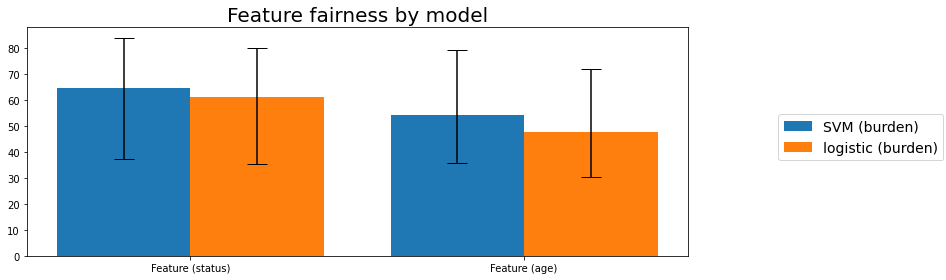

In [68]:
# Many scores also come with 95% confidence bounds, which we omitted above for the sake of brevity, but
# we can include those also.  In the example here we include the confidence bounds but only display the scores
# to a reduced level of detail to keep a smallish table for display purposes
df = construct_scores_dataframe(scores('fairness', result, max_depth=1))
display(df)

print("\n")

# Let's chart the fairness measure by feature for each model together with its confidence bounds for
# easier visual comparison:
%matplotlib inline
import matplotlib.pyplot as plt

features = ['Feature (status)', 'Feature (age)']
feature_scores = df[features]
feature_lower_bounds = df[[f + ' lower bound' for f in features]]
feature_upper_bounds = df[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Feature fairness by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df.index[idx],
            capsize=10)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()


## Resource Cleanup


- In this tutorial we
 - created and registered `logistic_model_azure` and `svm_model_azure` models to our Azure workspace
 - created `german-credit-logistic-service` and `german-credit-svm-service` ACI (Azure Container Instance) webservices 

- Once Cortex Certifai evaluation is complete, make sure to clear all azure resources in order to avoid cost
- Follow the [Azure Ml resource cleanup docs][1] to remove all resources created above

[1]:https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-1st-experiment-sdk-train#clean-up-resources